# Double Pendulum

Created 04-15-19 by Lucas Nestor  
Revised 04-22-19 by Lucas Nestor

In this notebook we will solve the equations of motion for a double pendulum. The energies are given by the following:

$\quad U=(m_1 + m_2) g L_1 (1 - \cos\theta_1) + m_2 g L_2 (1 - \cos\theta_2)$

$\quad T=\frac{1}{2}(m_1 + m_2) L_1^2 \dot \theta_1^2 + m_2 L_1 L_2 \dot \theta_1 \dot \theta_2 \cos(\theta_1 - \theta_2) + \frac{1}{2} m_2 L_2^2 \dot \theta_2^2$

Solving the the Lagrange equations yields the following:

$\quad (m_1 + m_2) L_1^2 \ddot \theta_1 + m_2 L_1 L_2 \ddot \theta_2 \cos(\theta_1 - \theta_2) - m_2 L_1 L_2 \dot \theta_2 \sin(\theta_1 - \theta_2)(\dot \theta_1 - \dot \theta_2) = -(m_1 + m_2) g L_1 \sin(\theta_1) - m_2 L_1 L_2 \dot \theta_1 \dot \theta_2 \sin(\theta_1 - \theta_2)$

$\quad m_2 L_1 L_2 \ddot \theta_1 \cos(\theta_1 - \theta_2) - m_2 L_1 L_2 \dot \theta_1 \sin(\theta_1 - \theta_2) (\dot \theta_1 - \dot \theta_2) + m_2 L_2^2 \ddot \theta_2 = m_2 L_1 L_2 \dot \theta_1 \dot \theta_2 \sin(\theta_1 - \theta_2) - m_2 g L_2 \sin(\theta_2)$

We will make this equation a matrix equation.

$\quad \mathbf{M} \ddot \theta = -\mathbf{h}$

where **M** and __h__ are defined as below.

$\quad\begin{align}
    \mathbf{M} = \left( \begin{array}{c c}
                         (m_1 + m_2) L_1^2 & m_2 L_1 L_2 \cos(\theta_1 - \theta_2) \\
                         m_2 L_1 L_2 \cos(\theta_1 - \theta_2) & m_2 L_2^2  \\
                      \end{array}   
                       \right)
    \qquad\qquad
    \mathbf{h} = \left( \begin{array}{c c}
                         (m_1 + m_2) g L_1 \sin(\theta_1) + m_2 L_1 L_2 \dot \theta_2^2 \sin(\theta_1 - \theta_2)\\
                         m_2 g L_2 \sin(\theta_2) - m_2 L_1 L_2 \dot \theta_1^2 \sin(\theta_1 - \theta_2) \\
                      \end{array}   
                       \right)
\end{align}$

In [2]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [3]:
class DoublePendulum():
    """
    Implements Langrange's equations for a double pendulum.
    """
    
    def __init__(self, m1=1., m2=1., L1=1., L2=1., g=1.):
        self.m1 = m1
        self.m2 = m2
        self.L1 = L1
        self.L2 = L2
        self.g = g
        
    def M_matrix(self, y):
        """
        Returns the matrix multiplying the second time derivative of theta.
        
        Parameters
        ==========
        y : float
            A vector with y[0] = theta_1, y[1] = theta_2, y[2] = dtheta_1/dt, y[3] = dtheta_2/dt
        """
        theta_1 = y[0]
        theta_2 = y[1]
        cosine = np.cos(theta_1 - theta_2)
        
        return np.array([
            [(self.m1 + self.m2) * self.L1**2    , self.m2 * self.L1 * self.L2 * cosine],
            [self.m2 * self.L1 * self.L2 * cosine, self.m2 * self.L2**2             ]
        ])
    
    def h_vec(self, y):
        """
        Returns the RHS for the matrix form of Lagrange's equationa
        
        Parameters
        ==========
        y : float
            A vector with y[0] = theta_1, y[1] = theta_2, y[2] = dtheta_1/dt, y[3] = dtheta_2/dt
        """
        theta_1 = y[0]
        theta_2 = y[1]
        theta_1_dot = y[2]
        theta_2_dot = y[3]
        sine = np.sin(theta_1 - theta_2)
        
        return np.array([
            [(self.m1 + self.m2) * self.g * self.L1 * np.sin(theta_1)
             + self.m2 * self.L1 * self.L2 * theta_2_dot**2 * sine],
            [self.m2 * self.g * self.L2 * np.sin(theta_2)
             - self.m2 * self.L1 * self.L2 * theta_1_dot**2 * sine]
        ])
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dtheta_vec/dt d^2theta_vec/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            vector with y[0] = theta_1, y[1] = theta_2, y[2] = dtheta_1/dt, y[3] = dtheta_2/dt
        """
        
        dy_dt_vec = np.zeros(4)
        dy_dt_vec[0:2] = y[2:4]
        dy_dt_vec[2:4] = (-1 * LA.inv(self.M_matrix(y)) @ self.h_vec(y)).T

        return dy_dt_vec
    
    def solve_ode(self, t_pts, y_0, abserr=1.0e-10, relerr=1.0e-10):
        return solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), y_0, t_eval=t_pts, rtol=relerr, atol=abserr).y

## Non-Chaotic Motion

At small angles, the motion of the two pendulums should not be chaotic. We will demonstrate this by taking $\theta_{1_0} = \theta_{2_0} = 0.01$ and $\dot \theta_{1_0} = \dot \theta_{2_0} = 0$.

Text(0.5,1,'Double Pendulum\n$\\theta_1(0) = $ 0.57 deg, $\\quad \\theta_2(0) = $ 0.57 deg, $\\quad \\dot \\theta_1(0) = $ 0.00, $\\quad \\dot \\theta_2(0) = $ 0.00')

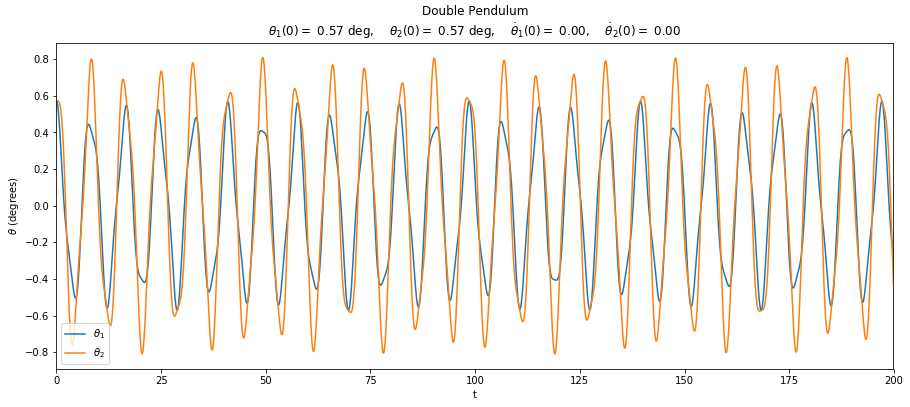

In [46]:
t_pts = np.arange(0., 200.0, 0.1)

theta_1_0 = theta_2_0 = 0.01
theta_1_dot_0 = theta_2_dot_0 = 0
initial_conditions = [theta_1_0, theta_2_0, theta_1_dot_0, theta_2_dot_0]

pend = DoublePendulum()
theta_1, theta_2, theta_1_dot, theta_2_dot = pend.solve_ode(t_pts, initial_conditions)

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,1,1)

ax.plot(t_pts, theta_1 * 180 / np.pi, label=r'$\theta_1$')
ax.plot(t_pts, theta_2 * 180 / np.pi, label=r'$\theta_2$')

ax.set_xlim(t_pts[0], t_pts[-1])
ax.set_xlabel('t')
ax.set_ylabel(r'$\theta$ (degrees)')
ax.legend(loc='lower left')

title = 'Double Pendulum\n' +  \
        rf'$\theta_1(0) = $ {theta_1_0 * 180 / np.pi:.2f} deg, ' + \
        rf'$\quad \theta_2(0) = $ {theta_2_0 * 180 / np.pi:.2f} deg, ' + \
        rf'$\quad \dot \theta_1(0) = $ {theta_1_dot_0:.2f}, ' + \
        rf'$\quad \dot \theta_2(0) = $ {theta_2_dot_0:.2f}'
ax.set_title(title)


Next we will check sensitivity to initial conditions. We expect the different between two pendulums started very close to not grow exponentially.

Text(0.5,1,'Double Pendulum\nPendulum 1: $\\theta_1(0) =$ 0.573 degrees, $\\quad \\theta_2(0) =$ 0.573 degrees\nPendulum 2: $\\theta_1(0) =$ 0.630 degrees, $\\quad \\theta_2(0) =$ 0.630 degrees')

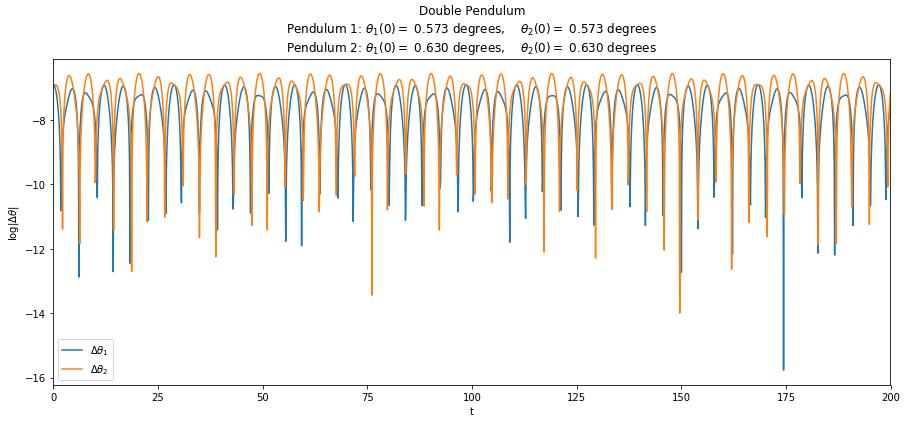

In [60]:
t_pts = np.arange(0., 200.0, 0.1)

theta_1_0 = theta_2_0 = 0.01
theta_1_dot_0 = theta_2_dot_0 = 0

diff = 0.001
initial_conditions_1 = [theta_1_0, theta_2_0, theta_1_dot_0, theta_2_dot_0]
initial_conditions_2 = [theta_1_0 + diff, theta_2_0 + diff, theta_1_dot_0, theta_2_dot_0]

pend = DoublePendulum()
theta_1_1, theta_2_1, _, _ = pend.solve_ode(t_pts, initial_conditions_1)
theta_1_2, theta_2_2, _, _ = pend.solve_ode(t_pts, initial_conditions_2)

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,1,1)

ax.plot(t_pts, np.log(np.abs(theta_1_1 - theta_1_2)), label=r'$\Delta \theta_1$')
ax.plot(t_pts, np.log(np.abs(theta_2_1 - theta_2_2)), label=r'$\Delta \theta_2$')

ax.set_xlim(t_pts[0], t_pts[-1])
ax.set_xlabel('t')
ax.set_ylabel(r'$\log|\Delta \theta|$')
ax.legend(loc='lower left')

title = 'Double Pendulum\n' +  \
        rf'Pendulum 1: $\theta_1(0) =$ {theta_1_0 * 180 / np.pi:.3f} degrees, ' + \
        rf'$\quad \theta_2(0) =$ {theta_2_0 * 180 / np.pi:.3f} degrees' + '\n' + \
        rf'Pendulum 2: $\theta_1(0) =$ {(theta_1_0 + diff) * 180 / np.pi:.3f} degrees, ' + \
        rf'$\quad \theta_2(0) =$ {(theta_2_0 + diff) * 180 / np.pi:.3f} degrees'
ax.set_title(title)

## Chaotic Motion

Next we will examine large initial angles. These should be chaotic, so we expect to see non-periodic motion.

Text(0.5,1,'Double Pendulum\n$\\theta_1(0) = $ 90.00 deg, $\\quad \\theta_2(0) = $ 90.00 deg, $\\quad \\dot \\theta_1(0) = $ 0.00, $\\quad \\dot \\theta_2(0) = $ 0.00')

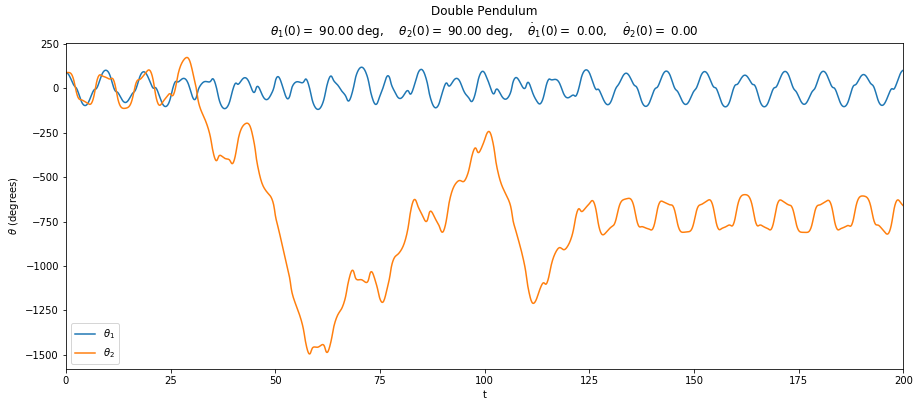

In [54]:
t_pts = np.arange(0., 200.0, 0.1)

theta_1_0 = theta_2_0 = np.pi / 2
theta_1_dot_0 = theta_2_dot_0 = 0
initial_conditions = [theta_1_0, theta_2_0, theta_1_dot_0, theta_2_dot_0]

pend = DoublePendulum()
theta_1, theta_2, theta_1_dot, theta_2_dot = pend.solve_ode(t_pts, initial_conditions)

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,1,1)

ax.plot(t_pts, theta_1 * 180 / np.pi, label=r'$\theta_1$')
ax.plot(t_pts, theta_2 * 180 / np.pi, label=r'$\theta_2$')

ax.set_xlim(t_pts[0], t_pts[-1])
ax.set_xlabel('t')
ax.set_ylabel(r'$\theta$ (degrees)')
ax.legend(loc='lower left')

title = 'Double Pendulum\n' +  \
        rf'$\theta_1(0) = $ {theta_1_0 * 180 / np.pi:.2f} deg, ' + \
        rf'$\quad \theta_2(0) = $ {theta_2_0 * 180 / np.pi:.2f} deg, ' + \
        rf'$\quad \dot \theta_1(0) = $ {theta_1_dot_0:.2f}, ' + \
        rf'$\quad \dot \theta_2(0) = $ {theta_2_dot_0:.2f}'
ax.set_title(title)

Now we will look at the sensitivity to initial conditions. We expect the different to increase until the two systems are completely different.

Text(0.5,1,'Double Pendulum\nPendulum 1: $\\theta_1(0) =$ 90.000 degrees, $\\quad \\theta_2(0) =$ 90.000 degrees\nPendulum 2: $\\theta_1(0) =$ 90.057 degrees, $\\quad \\theta_2(0) =$ 90.057 degrees')

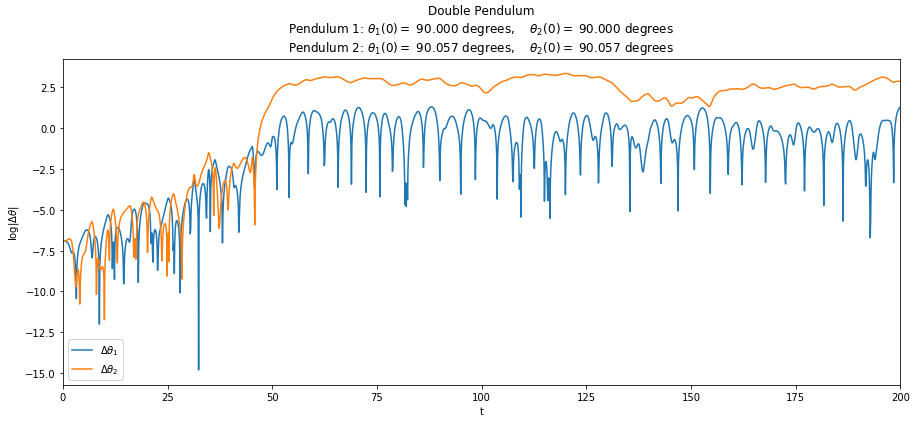

In [59]:
t_pts = np.arange(0., 200.0, 0.1)

theta_1_0 = theta_2_0 = np.pi / 2
theta_1_dot_0 = theta_2_dot_0 = 0

diff = 0.001
initial_conditions_1 = [theta_1_0, theta_2_0, theta_1_dot_0, theta_2_dot_0]
initial_conditions_2 = [theta_1_0 + difference, theta_2_0 + difference, theta_1_dot_0, theta_2_dot_0]

pend = DoublePendulum()
theta_1_1, theta_2_1, _, _ = pend.solve_ode(t_pts, initial_conditions_1)
theta_1_2, theta_2_2, _, _ = pend.solve_ode(t_pts, initial_conditions_2)

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,1,1)

ax.plot(t_pts, np.log(np.abs(theta_1_1 - theta_1_2)), label=r'$\Delta \theta_1$')
ax.plot(t_pts, np.log(np.abs(theta_2_1 - theta_2_2)), label=r'$\Delta \theta_2$')

ax.set_xlim(t_pts[0], t_pts[-1])
ax.set_xlabel('t')
ax.set_ylabel(r'$\log|\Delta \theta|$')
ax.legend(loc='lower left')

title = 'Double Pendulum\n' +  \
        rf'Pendulum 1: $\theta_1(0) =$ {theta_1_0 * 180 / np.pi:.3f} degrees, ' + \
        rf'$\quad \theta_2(0) =$ {theta_2_0 * 180 / np.pi:.3f} degrees' + '\n' + \
        rf'Pendulum 2: $\theta_1(0) =$ {(theta_1_0 + diff) * 180 / np.pi:.3f} degrees, ' + \
        rf'$\quad \theta_2(0) =$ {(theta_2_0 + diff) * 180 / np.pi:.3f} degrees'
ax.set_title(title)